## Voting Classifier (meta estimator)

In [3]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification


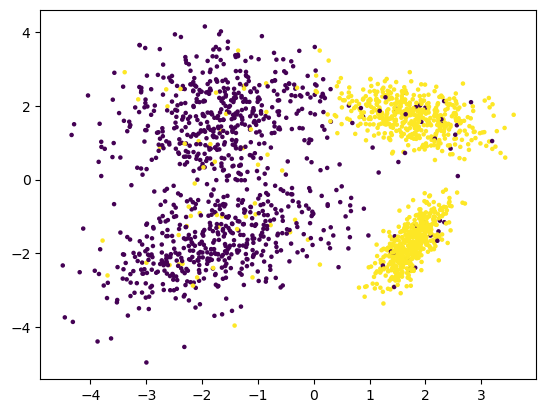

In [19]:
X, y = make_classification(n_samples=2000, n_features=2,
                          n_redundant=0, random_state=21,
                          class_sep=1.75, flip_y=0.1)
# plt.figure(figsize=(9,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s = 5);

voting classifier balances the estimators(different models)

to get pretty plots:

In [20]:
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

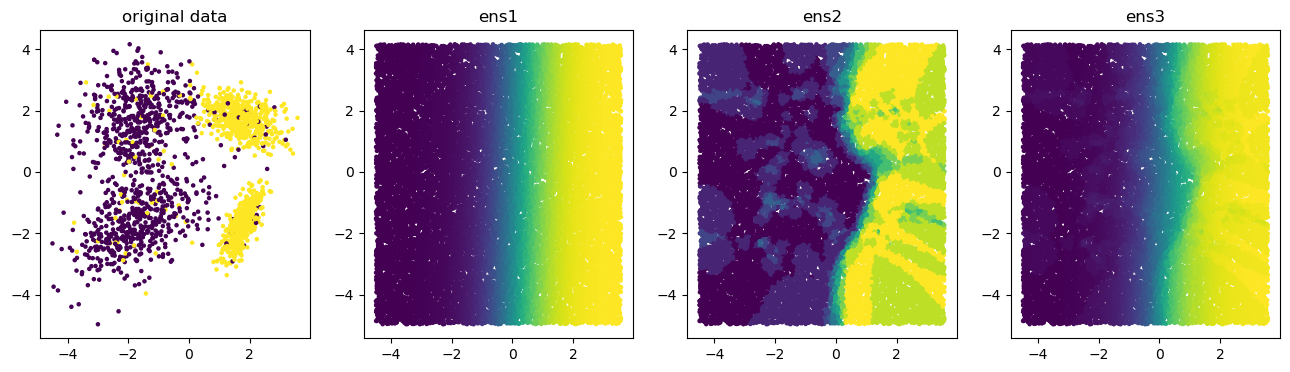

In [22]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)],
                        voting='soft', # average the predict proba values
                        weights=[10.5, 2.5]) # weight of each estimator
clf3.fit(X, y)

make_plots()